In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import prox_tv as ptv
import skimage.filters as filters

# C-SALSA2

In [4]:
def Psi_L(s, y, epsilon):
    """
    Equation 28 from
    
    Afonso, M. V., Bioucas-Dias, J. M., & Figueiredo, M. A. (2011). An augmented Lagrangian
    approach to the constrained optimization formulation of imaging inverse problems.
    IEEE Transactions on Image Processing, 20(3), 681-695.
    """
    t = s - y
    tn = np.linalg.norm(t)
    return y + (t if tn <= epsilon else t/tn)


def csalsa2(y, A, AT, proxTV, invLS, mu1, mu2, sigma, epsilon=None, 
            continuationFactor=1, P=None, PT=None, maxiter=10000, x_true=None):
    """
    C-SALSA-2 algorithm solving argmin{phi(Px)} subject to ||Ax - y||^2_2 <= epsilon.
    Short, w/o validation of arguments.
    
    Afonso, M. V., Bioucas-Dias, J. M., & Figueiredo, M. A. (2011). An augmented Lagrangian
    approach to the constrained optimization formulation of imaging inverse problems.
    IEEE Transactions on Image Processing, 20(3), 681-695.

    :param y: Observations.
    :param A: The function which computes products of the form A*x.
    :param AT: The function implementing the multiplication by the conjugate of A.
    :param proxTV: The Total Variation proximity operator.
    :param invLS: Function for multiplication with the term (mu I + A^T A)^(-1)
    :param mu1: Constraint weight. Must be greater than zero.
    :param mu2: Constraint weight. Must be greater than zero.
    :param sigma: Additive (Gaussian) noise variance.
    :param epsilon: Epsilon parameter in the inequality ||Ax-y|| < epsilon.
    :param P: The transform in analysis prior formulation (forward transform), P*PT = I
    :param PT: Inverse transform in analysis prior formulation.
    :param x_true: The true x required for computing of the MSE evolution.
    :return: returns (x, criterion, distance1, distance2, mses), where x is a solution,
    criterion is a sequence of values of ||A x - y ||, distance1 and distance2 are the sequences of
    values of the constrant function, and mses is the sequence of MSE values with respect to x_true.
    """
    if P is None or PT is None:
        P = lambda t: t
        PT = lambda t: t
    
    ATy = AT(y)  
    x = np.zeros_like(ATy)
    PTx = PT(x)
    
    v1 = np.zeros_like(PTx)
    v2 = np.zeros_like(y)
    d1 = np.zeros_like(v1)
    d2 = np.zeros_like(y)
    
    Ax = A(x)
    
    tolA = 0.001
    tau = mu1/mu2
    if epsilon is None:
        epsilon = np.sqrt(y.size + 8 * np.sqrt(y.size)) * sigma
    
    stop_flag = False
    criterion = [np.linalg.norm(Ax - y)]
    stop_criterion = []
    distance1 = [np.linalg.norm(Ax - y - v2)]
    distance2 = [np.linalg.norm(PTx - v1)]
    
    mses = []
    if x_true is not None:
        mses.append( np.sum((x-x_true)**2)/x.size )
    
    for i in np.arange(2, maxiter):
        mu1_inv = 1.0 / mu1
        mu2_inv = 1.0 / mu2
        x_prev = x
        
        r = mu1 * P(v1 + d1) + mu2 * AT(v2 + d2)
        x = invLS(r, mu1)
        
        PTx = PT(x)
        v1 = proxTV(np.real(PTx - d1), mu1_inv)
        
        Ax = A(x)        
        v2 = Psi_L(Ax - d2, y, epsilon)
        
        d1 = d1 - PTx + v1
        d2 = d2 - Ax + v2
        
        mu1 = mu1 * continuationFactor
        mu2 = mu2 * continuationFactor
        
        criterion.append(np.linalg.norm(Ax - y))
        distance1.append(np.linalg.norm(Ax - y - v2))
        distance2.append(np.linalg.norm(PTx - v1))
        if x_true is not None:
            mses.append( np.sum((x-x_true)**2)/x.size )
        
        stop_criterion.append( np.abs(criterion[-1] - criterion[-2])/criterion[-1] )
        stop_flag = (stop_criterion[-1] < tolA) and (criterion[-1] <= epsilon);
        
        if stop_flag:
            print "Stop criterion satisfied!"
            break
         
    return (x, criterion, distance1, distance2, mses)

# MRI imaging

In [5]:
def fft2c(x):
    return 1 / np.sqrt(np.prod(x.shape)) * np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x)))
    return 1 / np.sqrt(np.prod(x.shape)) * np.fft.fft2(np.fft.ifftshift(x))

def ifft2c(y):
    return np.sqrt(np.prod(y.shape)) * np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(y)))

def create_sampling_mask(N, angles):
    M = np.zeros((N, N), dtype=np.int32)
    N_2 = np.int32(0.5 * N)
    for angle in angles:
        if angle <= np.pi/4.0 or angle > 3.0*np.pi/4.0:
            yr = np.round(np.tan(angle) * np.arange(-N_2 + 1, N_2)) + N_2
            xr = np.arange(1, N, dtype=np.int32)
        else:
            xr = np.round(1.0/np.tan(angle) * np.arange(-N_2 + 1, N_2)) + N_2
            yr = np.arange(1, N, dtype=np.int32)
                
        for y, x in np.int32(zip(yr, xr)):
            M[y, x] = 1
        
    return M

# Experiment

/home/ws/zw0278/dev/simulation/lib/python2.7/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,1,'MSE on iteration.')

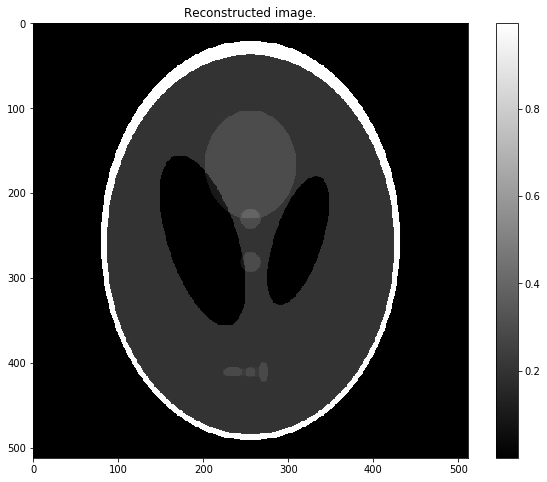

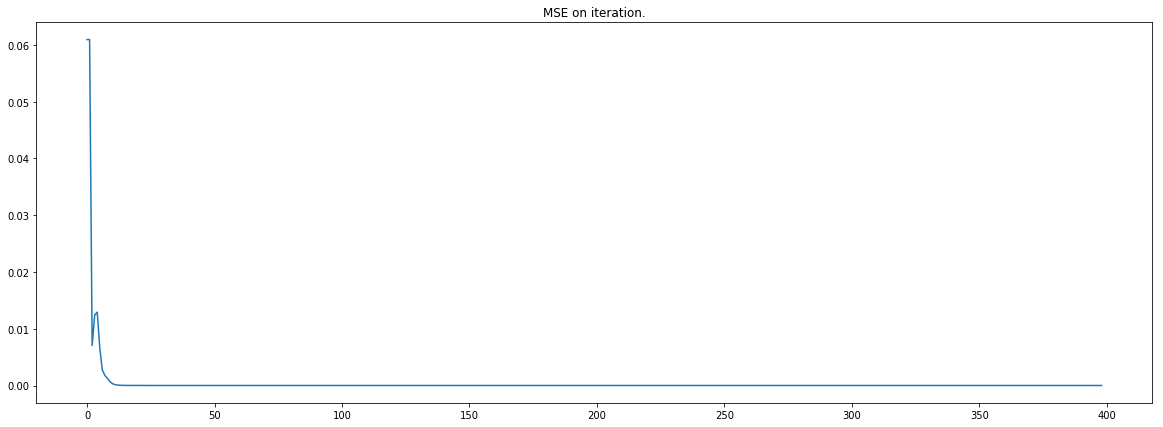

In [7]:
angles = np.deg2rad(np.linspace(0, 180, 60))

phantom = np.load("./phantom.npy")
phantom = phantom / np.max(phantom)

#
# C-SALSA parameters
stop_th = 1e-6
mu1 = 1
mu2 = mu1
tau = mu1 / mu2
sigma = 1e-3/np.sqrt(2)
iters = 400

#
# Create operators for C-SALSA
fft_phantom = fft2c(phantom)
sampling_mask = create_sampling_mask(fft_phantom.shape[0], angles)

A = lambda x: fft2c(x) * sampling_mask
AT = lambda y: ifft2c(y * sampling_mask)
ATA = lambda x: ifft2c(sampling_mask * fft2c(x))
invLS = lambda x, mu1: (1.0/mu1) * (x - (1.0/(1+tau)) * ATA(x))

# Add some noise to the measurements
y = A(phantom)
y = y + sigma*(np.random.randn(y.size).reshape(y.shape) + 1j*np.random.randn(y.size).reshape(y.shape))

#
# Reconstruction
epsilon = np.sqrt(y.size + 8 * np.sqrt(y.size)) * sigma
x, _, _, _, mses = csalsa2(y, A, AT, ptv.tv1_2d, invLS, mu1, mu2, sigma, epsilon, maxiter=iters, x_true=phantom)

#
# Plot results
plt.figure(figsize=(10,8))
plt.imshow(np.real(x), cmap='gray')
plt.title("Reconstructed image.")
plt.colorbar()

plt.figure(figsize=(20,7))
plt.plot(mses)
plt.title("MSE on iteration.")

# Pereyra

In [19]:
# Marcelo Pereyra. Maximum-a-posteriori estimation with bayesian confidence
# regions. SIAM Journal on Imaging Sciences, 10(1):285–302, 2017.

def TV(x):
    gy, gx = np.gradient(x)
    g = np.abs(gy) + np.abs(gx)
    return np.sum(g)

def compute_approx_credible_threshold(F, x, alpha=0.01):
    """
    Marcelo Pereyra. Maximum-a-posteriori estimation with bayesian confidence
    regions. SIAM Journal on Imaging Sciences, 10(1):285–302, 2017.
    """
    N = x.size
    tau = np.sqrt(16 * np.log(3.0 / alpha) * N)
    level = F(x) + tau + np.sqrt(N)
    return level

#
# Segment the ovals in the down part of the phantom
r0, r1 = 390, 430
c0, c1 = 220, 280
ovals_segmented = np.real(x[r0:r1, c0:c1])
thresh = filters.threshold_otsu(ovals_segmented)
binary = ovals_segmented > thresh

rr, cc = np.where(binary == 1)
rr = rr + r0
cc = cc + c0

#
# Compute thresholding (a scalar value) defining the credible set
F = lambda x: np.linalg.norm(A(x) - y)/(2 * sigma**2) + TV(x)
credibleThreshold = compute_approx_credible_threshold(F, np.real(x))

#
# Create a range of intensities which will be assigned to the ovals
# and validated using UQ.
intensities = np.arange(0.24, 0.40, 0.01)

decisions = []
x_surr = np.copy(x)
for intensity in intensities:
    x_surr[rr, cc] = intensity
    val = F(x_surr)
    # If val >= credibleThreshold, then the structure intensity was significantly changed
    decisions.append((val, val < credibleThreshold, intensity))

#
# Show acceptable intensity values
for value, inCredibleSet, intensity in decisions:
    if inCredibleSet:
        print "{:.3f} \t {} \t {:.3f}".format(value, inCredibleSet, intensity)


997163.725 	 True 	 0.290
994390.994 	 True 	 0.300


# Appendix: Limited angle MRI

Text(0.5,1,'MSE on iteration.')

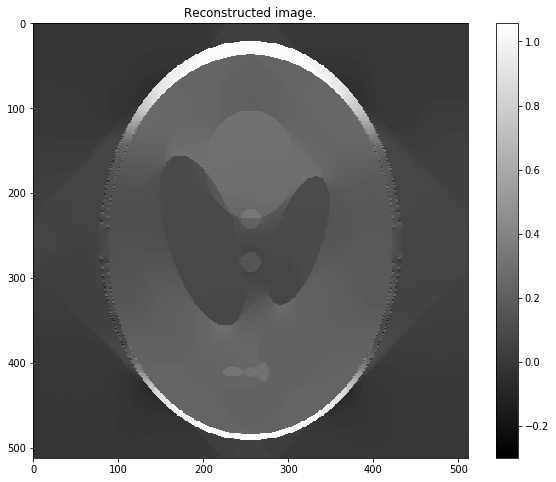

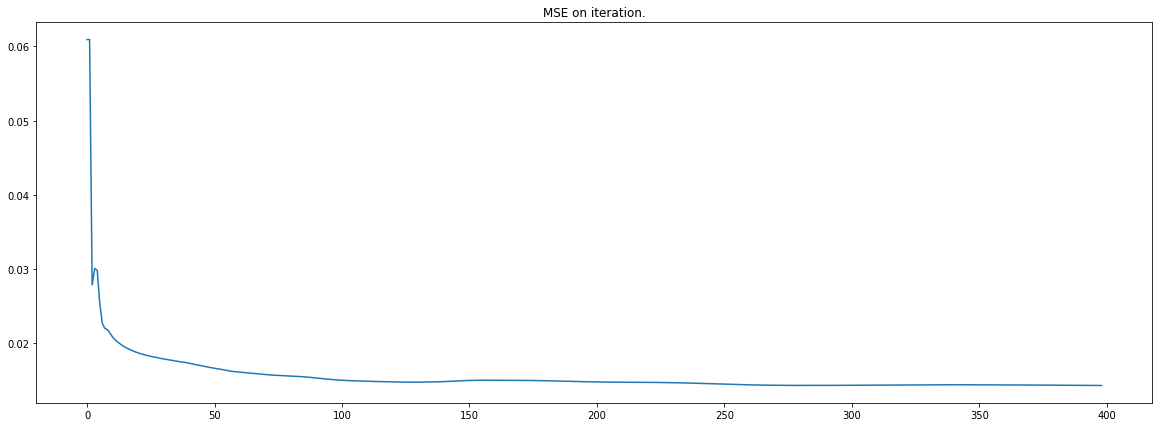

In [20]:
angles = np.deg2rad(np.linspace(45, 135, 200))

phantom = np.load("./phantom.npy")
phantom = phantom / np.max(phantom)

#
# C-SALSA parameters
stop_th = 1e-6
mu1 = 1
mu2 = mu1
tau = mu1 / mu2
sigma = 1e-3/np.sqrt(2)
iters = 400

#
# Create operators for C-SALSA
fft_phantom = fft2c(phantom)
sampling_mask = create_sampling_mask(fft_phantom.shape[0], angles)

A = lambda x: fft2c(x) * sampling_mask
AT = lambda y: ifft2c(y * sampling_mask)
ATA = lambda x: ifft2c(sampling_mask * fft2c(x))
invLS = lambda x, mu1: (1.0/mu1) * (x - (1.0/(1+tau)) * ATA(x))

# Add some noise to the measurements
y = A(phantom)
y = y + sigma*(np.random.randn(y.size).reshape(y.shape) + 1j*np.random.randn(y.size).reshape(y.shape))

#
# Reconstruction
epsilon = np.sqrt(y.size + 8 * np.sqrt(y.size)) * sigma
x, _, _, _, mses = csalsa2(y, A, AT, ptv.tv1_2d, invLS, mu1, mu2, sigma, epsilon, maxiter=iters, x_true=phantom)

#
# Plot results
plt.figure(figsize=(10,8))
plt.imshow(np.real(x), cmap='gray')
plt.title("Reconstructed image.")
plt.colorbar()

plt.figure(figsize=(20,7))
plt.plot(mses)
plt.title("MSE on iteration.")